# Testing emulator performance

This notebook evaluates the performance of trained looti emulators for a set of cosmological observables

Import Packages

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from looti import dictlearn as dcl
from looti import datahandle as dhl

Specify the path to the folder containing the saved data set and emulator for all observables

In [2]:
load_path = '../interpolators/redshift_0/'

## Linear power spectrum $P_{lin}$

Load the data set and the trained emulator

In [3]:
emulation_data = pickle.load(open(load_path + 'pca9_nrsts200_aniso_data.sav', 'rb'))
intobj = pickle.load(open(load_path + 'pca9_nrsts200_aniso.sav', 'rb'))

In [4]:
n_train = emulation_data.train_size
npca = intobj.ncomp
data_type = emulation_data.data_type
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
fgrid = emulation_data.fgrid

In [5]:
df_ext = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Plin_z0.csv', index_col=list(range(14)))
df_ref = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Plin_z0_ref.csv', index_col=list(range(2)))

In [6]:
n_plot_train = 10

In [7]:
xtrain = intobj.trainspace_normed
truth_normed_pcas_train = intobj.representation
prediction_pca_train, std_pca_train = intobj.gp_regressor.predict(xtrain, return_std=True)

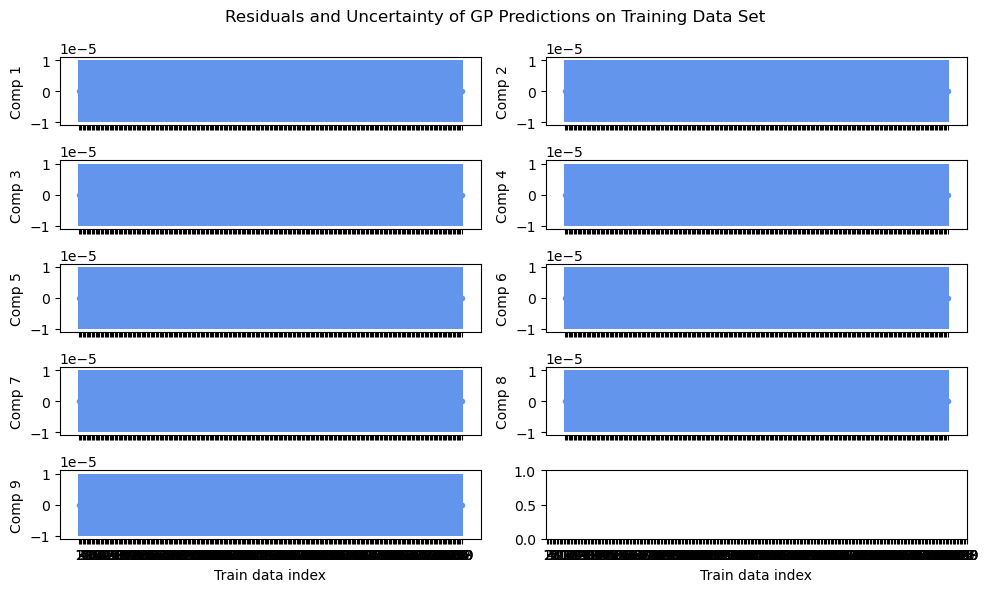

In [8]:
n_test = n_plot_train
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))

fig.suptitle('Residuals and Uncertainty of GP Predictions on Training Data Set')

for comp in range(npca):
    axs.ravel()[comp].errorbar(grid, 
                 truth_normed_pcas_train[:n_plot_train][:,comp]-prediction_pca_train[:n_plot_train][:,comp], 
                 yerr=std_pca_train[:n_plot_train][:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_test+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Train data index')
    axs[-1, i].set_xticks(list(range(1, n_test+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [9]:
binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std

In [10]:
nparam = emulation_data.num_parameters + int(emulation_data.multiple_z)
if emulation_data.multiple_z:
    params = ['z']
else:
    params = []
params += list(emulation_data.paramnames_dict.values())

In [11]:
test_indices = emulation_data.test_splitdict[0]
truth_spectrum = emulation_data.df_ext.loc['Plin'].values[test_indices]
ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.reconstruct_data(emulation_data.test_samples, pca_norm=True)

In [97]:
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [98]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]
    index_list = emulation_data.data_type, 0.0, params[0], indexvalues[0], params[1], indexvalues[1], params[2], indexvalues[2], params[3], indexvalues[3], params[4], indexvalues[4], params[5], indexvalues[5]

    truth_spectrum_test = emulation_data.df_ext.loc[index_list].values.flatten()
    
    ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()



    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

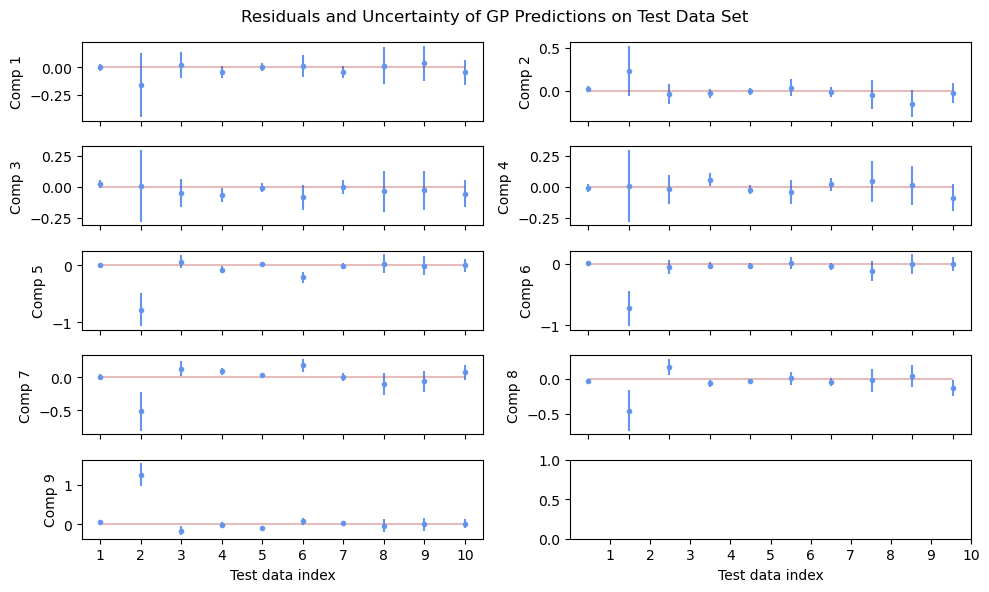

In [99]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp in range(npca):
    axs.ravel()[comp].errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_test+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticks(list(range(1, n_test+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [103]:
plot_index = 1

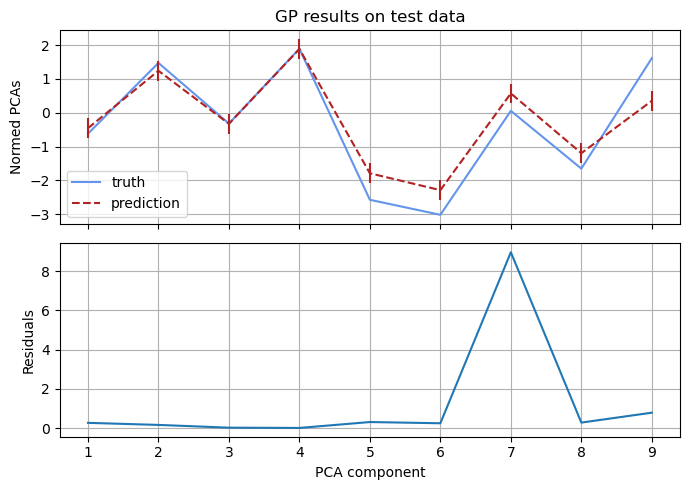

In [104]:
fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

ax[0].plot(np.linspace(1, npca, npca), truth_normed_pcas[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_normed_pcas[plot_index]))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

Text(0, 0.5, 'Residuals')

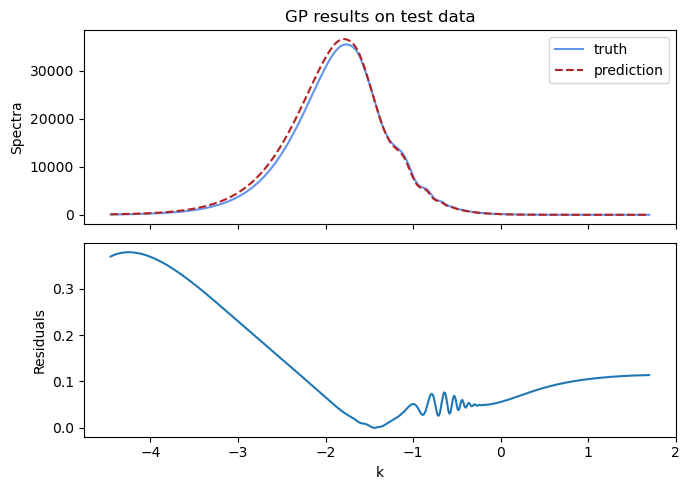

In [105]:
prediction_spectrum_normed_test = intobj.reconstruct_data(emulation_data.test_samples, pca_norm=True)
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_test[plot_index].flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test[plot_index].flatten() / truth_spectrum[plot_index])
ax[1].plot(fgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')